# Bureau and Bureau Balance

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
save_files = True

In [3]:
df_train = pd.read_csv('input/application_train.csv',index_col='SK_ID_CURR')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


## Bureau Balance

In [4]:
# load bureau balance file
df_balance = pd.read_csv('input/bureau_balance.csv')
df_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [5]:
display(df_balance[df_balance['SK_ID_BUREAU']==5715797].head(10))
display(df_balance['STATUS'].value_counts())

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
536,5715797,0,0
537,5715797,-1,1
538,5715797,-2,1
539,5715797,-3,0
540,5715797,-4,0
541,5715797,-5,0
542,5715797,-6,0
543,5715797,-7,2
544,5715797,-8,1
545,5715797,-9,0


C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [6]:
# select numeric statuses only
rows = (df_balance.STATUS!='X') & (df_balance.STATUS!='C')
cols = ['SK_ID_BUREAU','STATUS']
status = df_balance.loc[rows,cols].astype(int)

# aggregate status info
funcs = ['mean','max','first','std','sum'] # first gives most recent status
status = status.groupby('SK_ID_BUREAU').agg(funcs)

# rename columns
status.columns = ['BAL_'+'_'.join(x) for x in status.columns.values]

# reset index so SK_ID_BUREAU a separate column
status.reset_index(inplace=True)

status.head(10)

,SK_ID_BUREAU,BAL_STATUS_mean,BAL_STATUS_max,BAL_STATUS_first,BAL_STATUS_std,BAL_STATUS_sum
0,5001710,0.000000,0,0,0.000000,0
1,5001711,0.000000,0,0,0.000000,0
2,5001712,0.000000,0,0,0.000000,0
3,5001716,0.000000,0,0,0.000000,0
4,5001717,0.000000,0,0,0.000000,0
5,5001718,0.076923,1,0,0.271746,2
6,5001719,0.000000,0,0,0.000000,0
7,5001720,0.194444,1,1,0.401386,7
8,5001721,0.000000,0,0,0.000000,0
9,5001722,0.425532,1,0,0.499769,20


## Bureau

In [7]:
# load bureau file
df_bureau = pd.read_csv('input/bureau.csv')
df_bureau.info()
display(df_bureau.head())
display(df_bureau.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1515143,386819,6706875,Active,currency 1,-1637,0,NaN,NaN,NaN,0,22500.0,0.0,0.0,0.0,Credit card,-1627,NaN
1515144,386819,6706876,Closed,currency 1,-1085,0,-516.0,-515.0,NaN,0,202500.0,0.0,0.0,0.0,Credit card,-514,0.0
1515145,386819,6706877,Closed,currency 1,-1122,0,-1029.0,-999.0,NaN,0,67252.5,0.0,0.0,0.0,Consumer credit,-962,0.0
1515146,386819,6706878,Closed,currency 1,-1048,0,-863.0,-860.0,NaN,0,900000.0,0.0,0.0,0.0,Consumer credit,-859,0.0
1515147,386819,6706880,Closed,currency 1,-2683,0,-2318.0,-2312.0,NaN,0,585000000.0,NaN,NaN,0.0,Consumer credit,-2312,NaN
1515148,386819,6706881,Closed,currency 1,-2511,0,-1417.0,-2431.0,NaN,0,13500000.0,NaN,NaN,0.0,Consumer credit,-2431,NaN
1515149,386819,6706882,Closed,currency 1,-2360,0,-1266.0,-1290.0,NaN,0,2250000.0,NaN,NaN,0.0,Consumer credit,-1290,NaN
1515150,386819,6706883,Closed,currency 1,-1637,0,-1272.0,-1272.0,NaN,0,1125000.0,0.0,NaN,0.0,Consumer credit,-1270,112887.0
1515151,386819,6706884,Closed,currency 1,-1121,0,-1029.0,-1029.0,NaN,0,67252.5,0.0,NaN,0.0,Consumer credit,-1025,0.0
1515152,386819,6706885,Closed,currency 1,-1132,0,-189.0,-189.0,NaN,0,2565000.0,0.0,NaN,0.0,Consumer credit,-181,0.0


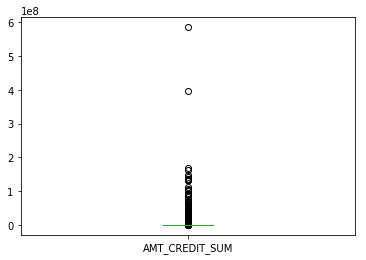

In [8]:
# customer with apparently ~100 million credit, including 3 million for a car?
display(df_bureau[df_bureau.SK_ID_CURR==386819])

df_bureau.AMT_CREDIT_SUM.plot.box()

In [9]:
print('bureau.csv unique ids:',df_bureau.SK_ID_BUREAU.nunique())
print('bureau_balance.csv unique ids:',df_balance.SK_ID_BUREAU.nunique())
print('bureau ids in bureau_balance:',df_bureau.SK_ID_BUREAU.isin(df_balance.SK_ID_BUREAU.unique()).sum())

bureau.csv unique ids: 1716428
bureau_balance.csv unique ids: 817395
bureau ids in bureau_balance: 774354


In [10]:
# merge status history from bureau_balance.csv with bureau.csv
df_bureau = df_bureau.merge(status, how='left', on='SK_ID_BUREAU')

display(df_bureau[status.columns].describe())

# don't need the bureau id anymore
df_bureau.drop('SK_ID_BUREAU',axis=1,inplace=True)

# don't need balance df anymore
del df_balance, status

,SK_ID_BUREAU,BAL_STATUS_mean,BAL_STATUS_max,BAL_STATUS_first,BAL_STATUS_std,BAL_STATUS_sum
count,1.716428e+06,663424.000000,663424.000000,663424.000000,625971.000000,663424.000000
mean,5.924434e+06,0.047949,0.196526,0.078399,0.072450,0.854708
std,5.322657e+05,0.261549,0.590204,0.438503,0.223499,8.068886
min,5.000000e+06,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.463954e+06,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.926304e+06,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.385681e+06,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.843457e+06,5.000000,5.000000,5.000000,3.535534,445.000000


In [11]:
# shorten some strings
df_bureau['CREDIT_ACTIVE'] = df_bureau['CREDIT_ACTIVE'].replace({'Bad debt':'Bad'})
df_bureau['CREDIT_CURRENCY'] = df_bureau['CREDIT_CURRENCY'].str.replace('currency ','')
df_bureau['CREDIT_TYPE'] = df_bureau['CREDIT_TYPE'].replace({'Another type of loan':'Other',
                                                             'Car loan':'Car',
                                                             'Cash loan (non-earmarked)':'Cash',
                                                             'Consumer credit':'Consumer',
                                                             'Credit card':'Card',
                                                             'Interbank credit':'Interbank',
                                                             'Loan for business development':'Business',
                                                             'Loan for purchase of shares (margin lending)':'Shares',
                                                             'Loan for the purchase of equipment':'Equipment',
                                                             'Loan for working capital replenishment':'Capital',
                                                             'Mobile operator loan':'Mobile',
                                                             'Real estate loan':'Estate',
                                                             'Unknown type of loan':np.nan})

In [12]:
# convert all categoricals to dummies
numeric_cols = [col for col in df_bureau.columns if df_bureau[col].dtype is not 'object']
df_bureau = pd.get_dummies(df_bureau,columns=['CREDIT_CURRENCY','CREDIT_TYPE'])

exclude_cols = ['SK_ID_CURR','CREDIT_ACTIVE']
dummy_cols = [col for col in df_bureau.columns if col not in numeric_cols and col not in exclude_cols]
numeric_cols = [col for col in df_bureau.columns if col not in dummy_cols and col not in exclude_cols]

df_bureau.describe()

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,CREDIT_TYPE_Cash,CREDIT_TYPE_Consumer,CREDIT_TYPE_Equipment,CREDIT_TYPE_Estate,CREDIT_TYPE_Interbank,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Other,CREDIT_TYPE_Shares
count,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,...,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06
mean,2.782149e+05,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,...,3.262590e-05,7.291975e-01,1.106950e-05,1.573034e-05,5.826053e-07,7.231879e-03,5.826053e-07,1.071469e-02,5.925096e-04,2.330421e-06
std,1.029386e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,...,5.711817e-03,4.443744e-01,3.327068e-03,3.966120e-03,7.632858e-04,8.473242e-02,7.632858e-04,1.029558e-01,2.433431e-02,1.526570e-03
min,1.000010e+05,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.888668e+05,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.780550e+05,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.674260e+05,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.562550e+05,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [13]:
agg_funcs = {'SK_ID_CURR':'count'}
for col in dummy_cols:
    agg_funcs[col] = ['sum','mean']

for col in numeric_cols:
    agg_funcs[col] = ['sum','mean','max']

agg_funcs

{'AMT_ANNUITY': ['sum', 'mean', 'max'],
 'AMT_CREDIT_MAX_OVERDUE': ['sum', 'mean', 'max'],
 'AMT_CREDIT_SUM': ['sum', 'mean', 'max'],
 'AMT_CREDIT_SUM_DEBT': ['sum', 'mean', 'max'],
 'AMT_CREDIT_SUM_LIMIT': ['sum', 'mean', 'max'],
 'AMT_CREDIT_SUM_OVERDUE': ['sum', 'mean', 'max'],
 'BAL_STATUS_first': ['sum', 'mean', 'max'],
 'BAL_STATUS_max': ['sum', 'mean', 'max'],
 'BAL_STATUS_mean': ['sum', 'mean', 'max'],
 'BAL_STATUS_std': ['sum', 'mean', 'max'],
 'BAL_STATUS_sum': ['sum', 'mean', 'max'],
 'CNT_CREDIT_PROLONG': ['sum', 'mean', 'max'],
 'CREDIT_CURRENCY_1': ['sum', 'mean'],
 'CREDIT_CURRENCY_2': ['sum', 'mean'],
 'CREDIT_CURRENCY_3': ['sum', 'mean'],
 'CREDIT_CURRENCY_4': ['sum', 'mean'],
 'CREDIT_DAY_OVERDUE': ['sum', 'mean', 'max'],
 'CREDIT_TYPE_Business': ['sum', 'mean'],
 'CREDIT_TYPE_Capital': ['sum', 'mean'],
 'CREDIT_TYPE_Car': ['sum', 'mean'],
 'CREDIT_TYPE_Card': ['sum', 'mean'],
 'CREDIT_TYPE_Cash': ['sum', 'mean'],
 'CREDIT_TYPE_Consumer': ['sum', 'mean'],
 'CREDIT_TYP

In [14]:
bureau_grouped = df_bureau.groupby(['SK_ID_CURR','CREDIT_ACTIVE']).agg(agg_funcs)

del df_bureau

In [15]:
# remove multi-level column names
bureau_grouped.columns = ['_'.join(x) for x in bureau_grouped.columns.values]
bureau_grouped=bureau_grouped.unstack(fill_value=0)
bureau_grouped.columns = ['BURO_'+'_'.join(x) for x in bureau_grouped.columns.values]

# tidy up some column names
bureau_grouped.columns = bureau_grouped.columns.str.replace('SK_ID_CURR_','')
bureau_grouped.columns = bureau_grouped.columns.str.replace('CREDIT_CURRENCY_','CURRENCY_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('CREDIT_TYPE_','TYPE_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('CREDIT_DAY_OVERDUE_','DAY_OVER_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('DAYS_CREDIT_ENDDATE_','DAY_END_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('DAYS_ENDDATE_FACT_','DAY_END_FACT_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('AMT_CREDIT_MAX_OVERDUE_','MAX_OVER_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('CNT_CREDIT_PROLONG_','PROLONG_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('AMT_CREDIT_SUM_','CREDIT_SUM_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('AMT_CREDIT_SUM_DEBT_','DEBT_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('CREDIT_SUM_LIMIT_','LIMIT_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('AMT_CREDIT_SUM_OVERDUE_','AMT_OVER_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('DAYS_CREDIT_UPDATE_','DAY_UPDATE_')
bureau_grouped.columns = bureau_grouped.columns.str.replace('AMT_ANNUITY_','ANNUITY_')

In [16]:
bureau_grouped.head()

,BURO_count_Active,BURO_count_Bad,BURO_count_Closed,BURO_count_Sold,BURO_CURRENCY_1_sum_Active,BURO_CURRENCY_1_sum_Bad,BURO_CURRENCY_1_sum_Closed,BURO_CURRENCY_1_sum_Sold,BURO_CURRENCY_1_mean_Active,BURO_CURRENCY_1_mean_Bad,...,BURO_BAL_STATUS_sum_sum_Closed,BURO_BAL_STATUS_sum_sum_Sold,BURO_BAL_STATUS_sum_mean_Active,BURO_BAL_STATUS_sum_mean_Bad,BURO_BAL_STATUS_sum_mean_Closed,BURO_BAL_STATUS_sum_mean_Sold,BURO_BAL_STATUS_sum_max_Active,BURO_BAL_STATUS_sum_max_Bad,BURO_BAL_STATUS_sum_max_Closed,BURO_BAL_STATUS_sum_max_Sold
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0,4,0,3,0,4,0,1.0,0.0,...,0.0,0.0,0.333333,0.0,0.0,0.0,1.0,0.0,0.0,0.0
100002,2,0,6,0,2,0,6,0,1.0,0.0,...,21.0,0.0,3.000000,0.0,3.5,0.0,6.0,0.0,6.0,0.0
100003,1,0,3,0,1,0,3,0,1.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
100004,0,0,2,0,0,0,2,0,0.0,0.0,...,NaN,0.0,0.000000,0.0,NaN,0.0,0.0,0.0,NaN,0.0
100005,2,0,1,0,2,0,1,0,1.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_train = df_train.merge(bureau_grouped,how='left',left_index=True,right_index=True)
display(df_train.head())

df_test = pd.read_csv('input/application_test.csv',index_col='SK_ID_CURR')
df_test = df_test.merge(bureau_grouped,how='left',left_index=True,right_index=True)

if save_files:
    # select new columns from bureau files
    buro_cols = df_train.columns[df_train.columns.str.contains('BURO')]

    print('saving train...')
    df_train[buro_cols].to_csv('input/app_train_ALL_bureau.csv')
    
    print('saving test...')
    df_test[buro_cols].to_csv('input/app_test_ALL_bureau.csv')
    
del bureau_grouped

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,BURO_BAL_STATUS_sum_sum_Closed,BURO_BAL_STATUS_sum_sum_Sold,BURO_BAL_STATUS_sum_mean_Active,BURO_BAL_STATUS_sum_mean_Bad,BURO_BAL_STATUS_sum_mean_Closed,BURO_BAL_STATUS_sum_mean_Sold,BURO_BAL_STATUS_sum_max_Active,BURO_BAL_STATUS_sum_max_Bad,BURO_BAL_STATUS_sum_max_Closed,BURO_BAL_STATUS_sum_max_Sold
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,21.0,0.0,3.0,0.0,3.5,0.0,6.0,0.0,6.0,0.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0


saving train...
saving test...


## Visualisation

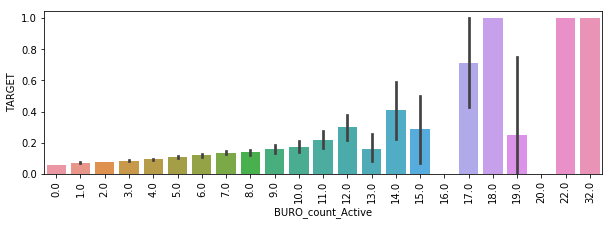

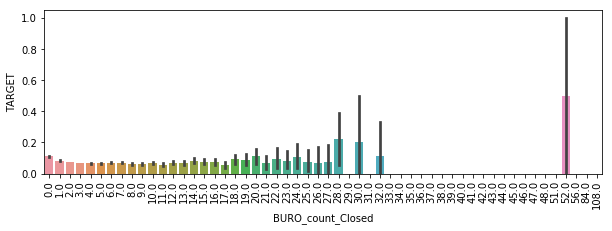

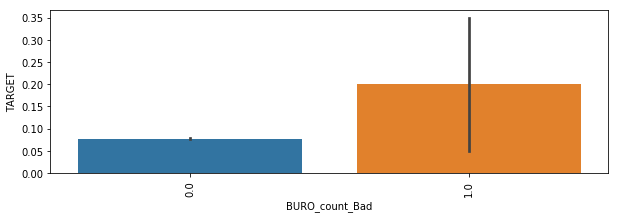

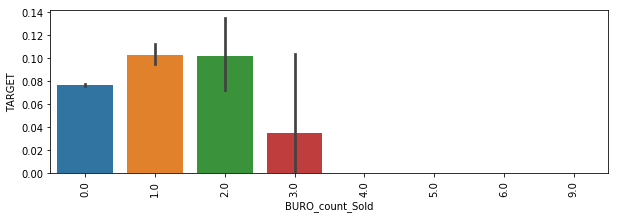

In [18]:
plt.figure(figsize=(10,3))
sns.barplot(x='BURO_count_Active',y='TARGET',data=df_train)
plt.xticks(rotation=90);

plt.figure(figsize=(10,3))
sns.barplot(x='BURO_count_Closed',y='TARGET',data=df_train)
plt.xticks(rotation=90);

plt.figure(figsize=(10,3))
sns.barplot(x='BURO_count_Bad',y='TARGET',data=df_train)
plt.xticks(rotation=90);

plt.figure(figsize=(10,3))
sns.barplot(x='BURO_count_Sold',y='TARGET',data=df_train)
plt.xticks(rotation=90);

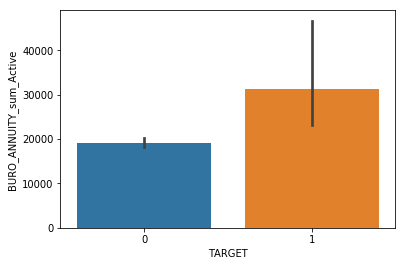

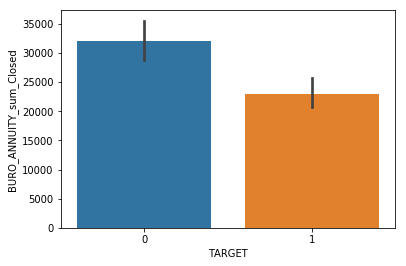

In [19]:
sns.barplot(y='BURO_ANNUITY_sum_Active',x='TARGET',data=df_train)
plt.figure()
sns.barplot(y='BURO_ANNUITY_sum_Closed',x='TARGET',data=df_train)


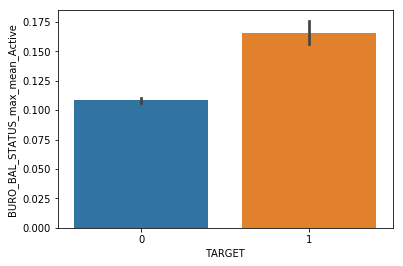

In [20]:
sns.barplot(y='BURO_BAL_STATUS_max_mean_Active',x='TARGET',data=df_train)


## Model

In [21]:
def plot_roc_curve(y_true, y_pred, color='darkorange',plot_random=True,label='ROC curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    score = roc_auc_score(y_true, y_pred)
    
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=label+' (area = %0.2f)' % score)
    
    if plot_random:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

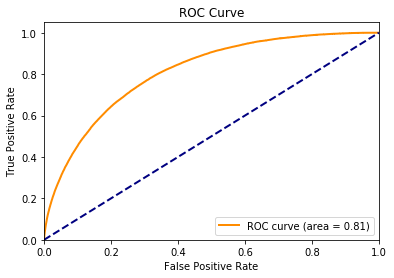

In [22]:
target_counts = df_train.TARGET.value_counts()
targ1_weight = target_counts[0]/target_counts[1]
weights = df_train.TARGET.replace({0:1, 1:targ1_weight}).values

dtypes = df_train.dtypes
cols_categ = dtypes[dtypes=='object'].index.tolist()
for col in cols_categ:
    df_train[col] = df_train[col].astype('category')
    
y_true = df_train.TARGET
X = df_train.drop('TARGET',axis=1)
train_data = lgb.Dataset(X, label=y_true, weight=weights)

    
# train
param = {'objective':'binary', 'metric':'auc'}
bst = lgb.train(param, train_data)

#plot roc curve
plt.figure()
plot_roc_curve(y_true, bst.predict(X))

EXT_SOURCE_3                        0.251998
EXT_SOURCE_2                        0.202084
ORGANIZATION_TYPE                   0.106960
EXT_SOURCE_1                        0.066855
AMT_CREDIT                          0.024846
AMT_GOODS_PRICE                     0.023230
OCCUPATION_TYPE                     0.022180
DAYS_BIRTH                          0.018913
AMT_ANNUITY                         0.017240
NAME_EDUCATION_TYPE                 0.017111
DAYS_EMPLOYED                       0.015647
CODE_GENDER                         0.014422
OWN_CAR_AGE                         0.013859
BURO_DAY_END_mean_Active            0.007770
BURO_DAY_END_max_Active             0.007750
NAME_CONTRACT_TYPE                  0.007624
DAYS_ID_PUBLISH                     0.007492
BURO_DAYS_CREDIT_max_Active         0.006869
BURO_CREDIT_SUM_sum_Closed          0.006111
BURO_CREDIT_SUM_DEBT_mean_Active    0.005607
DAYS_LAST_PHONE_CHANGE              0.005189
BURO_TYPE_Microloan_sum_Active      0.005033
FLAG_DOCUM

Text(0,0.5,'cumulative frac gain')

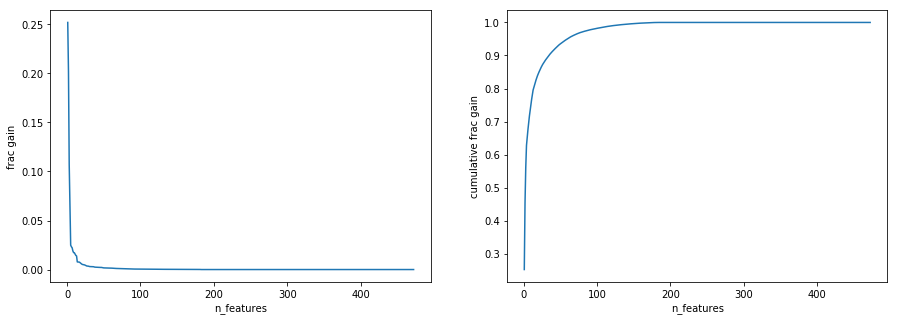

In [23]:

plt.figure(figsize=(10,30))

feat_imp = pd.DataFrame({'split':bst.feature_importance(importance_type='split'),
                         'gain':bst.feature_importance(importance_type='gain')},
                        index=bst.feature_name())

total_gain = feat_imp['gain'].sum()
frac_gain = feat_imp['gain']/total_gain
frac_gain = frac_gain.sort_values(ascending=False)

display(frac_gain.head(30))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(frac_gain))+1, frac_gain)
plt.xlabel('n_features')
plt.ylabel('frac gain')

plt.subplot(1,2,2)
plt.plot(np.arange(len(frac_gain))+1,frac_gain.cumsum())
plt.xlabel('n_features')
plt.ylabel('cumulative frac gain')

In [24]:
# select top n_buro columns from buro by importance
n_buro = 60
select_cols = frac_gain[frac_gain.index.str.contains('BURO')].index[:n_buro]

if save_files:
    df_train[select_cols].to_csv('input/app_train_SELECT_bureau.csv')
    df_test[select_cols].to_csv('input/app_test_SELECT_bureau.csv')